In [1]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/resnetwithoutnoise/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/resnetnoise/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 25:
        distance_high_indicates.append(i)
    elif mes_val < 0.6:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)
pred_diff_list = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i] or math.fabs(ref_scores[i] - tar_scores[i]) > 0.2:     
        pred_diff_list.append(i)
pred_diff_class = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i]:     
        pred_diff_class.append(i)

print('predict diff sample number:',len(pred_diff_list),'absolute align sample number:',len(same_indicates))

diff_combine_same = np.concatenate((same_indicates, pred_diff_list), axis=0)
# diff_combine_same.sort()
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
print('RBF Kernel CKA, between same subset: {}'.format(np_cka.kernel_CKA(ref_train_data[same_indicates], tar_train_data[same_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_list], tar_train_data[pred_diff_list])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_class], tar_train_data[pred_diff_class])))
print('RBF Kernel CKA, between same+diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 2023.45it/s]


predict diff sample number: 668 absolute align sample number: 161
RBF Kernel CKA, between same subset: 0.9562931169500843
RBF Kernel CKA, between diff subset: 0.7458487658771581
RBF Kernel CKA, between diff subset: 0.7589473538167805
RBF Kernel CKA, between same+diff subset: 0.7868589835539113


In [2]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    # train_steps = 100000
    for i in range(train_steps):
        if i%1000 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R


In [3]:
len(pred_diff_class)
ref_train_data = ref_provider.train_representation(200).squeeze()
ref_res_idx = list(zip(range(len(ref_prediction_res)),ref_prediction_res))
ref_scores_idx = list(zip(range(len(ref_scores)),ref_scores))

for i in range(len(pred_diff_class)):
    index = pred_diff_class[i]
    ###### find same prediction result in reference
    pred_res_in_target = tar_prediction_res[index]
    score = tar_scores[index]
    res_idx = list(filter(lambda x:x[1]==pred_res_in_target,ref_res_idx))

    res_idx = list(zip(*res_idx))[0]
    if len(res_idx):
        score_idx = list(filter(lambda x:np.logical_and(x[0] in res_idx,math.fabs(x[1] - score) < 0.1),ref_scores_idx))
        
        if len(score_idx):
            score_idx = list(zip(*score_idx))[0]
            if i%10 == 0:
                print('111',index, score_idx[0])
            ref_train_data[index] = ref_train_data[score_idx[0]]


    # print('res',pred_res_in_target, 'res',len(score_idx))

111 575 14107
111 1778 684
111 3797 1121
111 6026 27061
111 8635 9
111 10811 6264
111 12783 2921
111 15708 27
111 17305 1002
111 21254 8808
111 22720 9875
111 26399 9875
111 27961 2468
111 29949 9687
111 31872 6
111 34471 1
111 36134 1745
111 37466 6
111 40468 684
111 42653 684
111 45216 14107
111 47229 27
111 49896 1778


In [5]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
S_for_same = align_embeddings(X, Y, 35000)

iteration 0, loss 5919323.445495473
iteration 1000, loss 678.5816466770623
iteration 2000, loss 510.84898936278665
iteration 3000, loss 405.84435467067055
iteration 4000, loss 333.36665464595853
iteration 5000, loss 280.7298177760707
iteration 6000, loss 240.93505257219437
iteration 7000, loss 209.87697740303707
iteration 8000, loss 185.01304747229958
iteration 9000, loss 164.6925612100352
iteration 10000, loss 147.79994295241804
iteration 11000, loss 133.55524079480642
iteration 12000, loss 121.39722451306638
iteration 13000, loss 110.9119774514702
iteration 14000, loss 101.78766149723926
iteration 15000, loss 93.78494035803045
iteration 16000, loss 86.71709964967607
iteration 17000, loss 80.43635667598377
iteration 18000, loss 74.82422787748607
iteration 19000, loss 69.78461977025418
iteration 20000, loss 65.23878679609714
iteration 21000, loss 61.12159343931826
iteration 22000, loss 57.37870337812507
iteration 23000, loss 53.96443800533527
iteration 24000, loss 50.840125307549634
it

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 2516.08it/s]


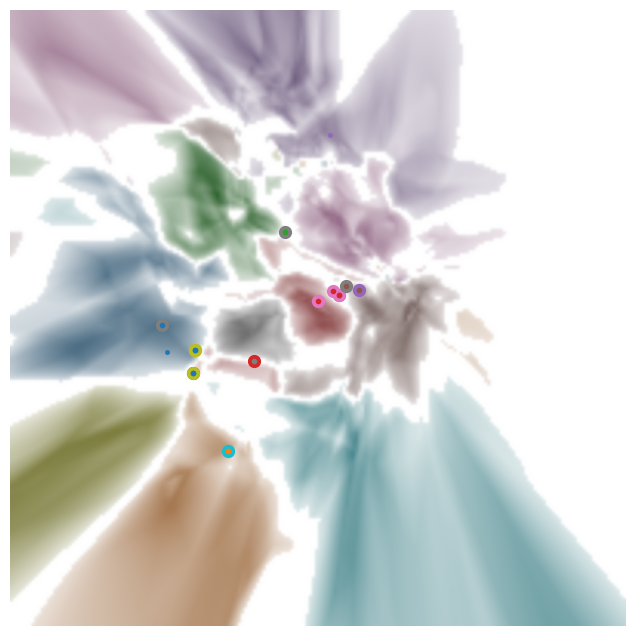

In [75]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider , S_for_same,I, ref_train_data, projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 2153.13it/s]


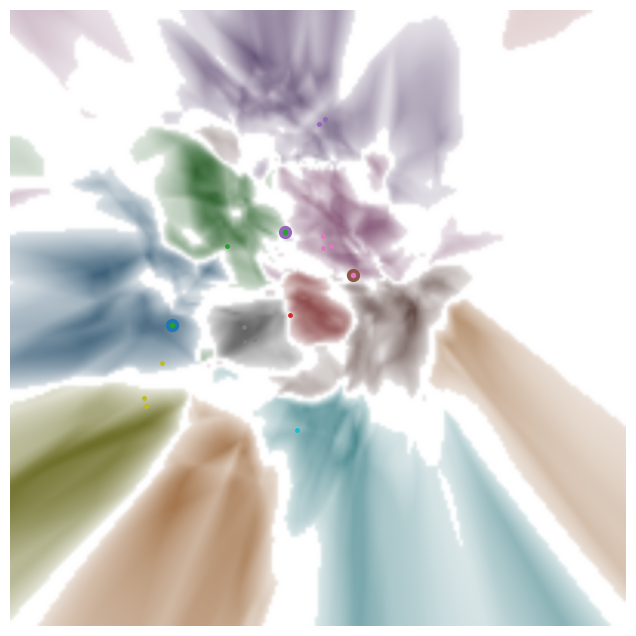

In [6]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
# use prediction differenct subset train S_for_diff, use S_for_diff generate diff predict samples
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
R_for_same = align_embeddings(Y, X, 35000)

In [ ]:
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# S = align_embeddings(X, Y, 25000)
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# R = align_embeddings(Y, X, 25000)
# adjusted

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [52]:
diff_combine_same = np.concatenate((pred_diff_list, same_indicates), axis=0)

In [ ]:
# np.concatenate(ref_train_data[same_indicates], np.array([ref_train_data[index]])).shape


# samelist.append(ref_train_data[0])
# la = np.append(samelist, ref_train_data[0], axis=None) 
# la.shape   
# print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same]))) 
stand = np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])                
for i in range(len(res_idx)):
    index = res_idx[i]
    samelist1 = ref_train_data[diff_combine_same]
    samelist1[0] = ref_train_data[index]

    if(stand - np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same]) < 0.001):
        print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same])))

    

    

In [ ]:
def find_sta_CKA(res_idx, need_adjust_index,ref_representations, tar_representations, threthold):
    """
        res_idx: search subset
        need_adjust_index: index of the need adjusted sample
        ref_representations: reference representation sub set
        tar_representations: target representation sub set
        threthold: current CKA
    """
    stand_val = np_cka.kernel_CKA(ref_representations, tar_representations)           
    idx = []
    for i in range(len(res_idx)):
        index = res_idx[i]
        ref_representations[need_adjust_index] = ref_train_data[index]

        if (stand_val - np_cka.kernel_CKA(ref_representations, tar_representations) < threthold):
            idx.append(index)
    return idx

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 1495.93it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

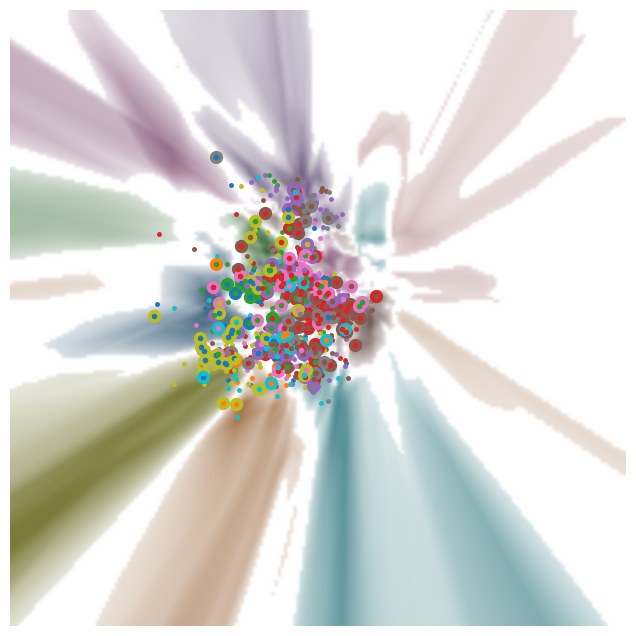

In [11]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 21/21 [00:00<00:00, 2112.70it/s]


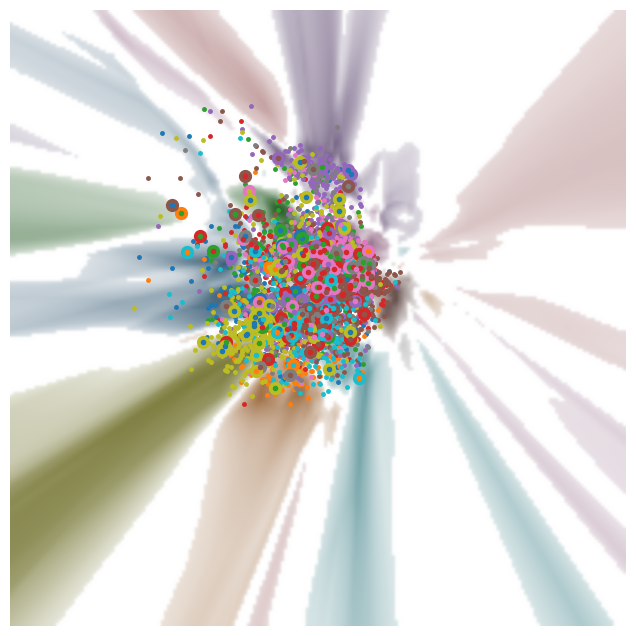

In [19]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 7772.41it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

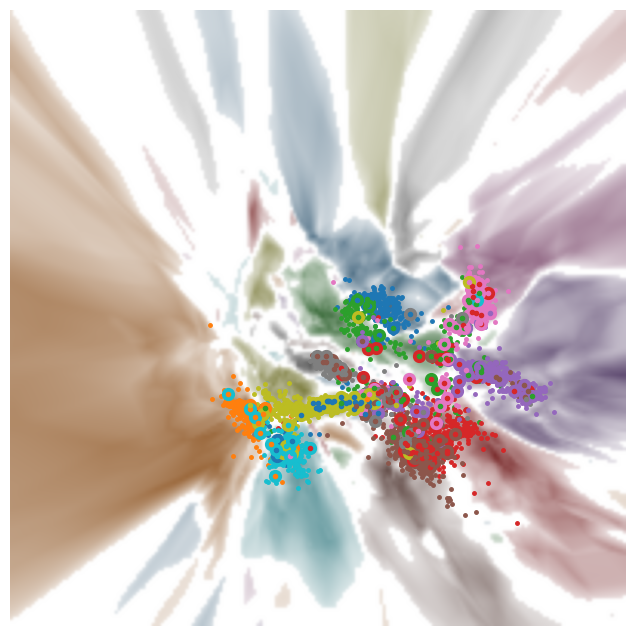

In [20]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 4595.47it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

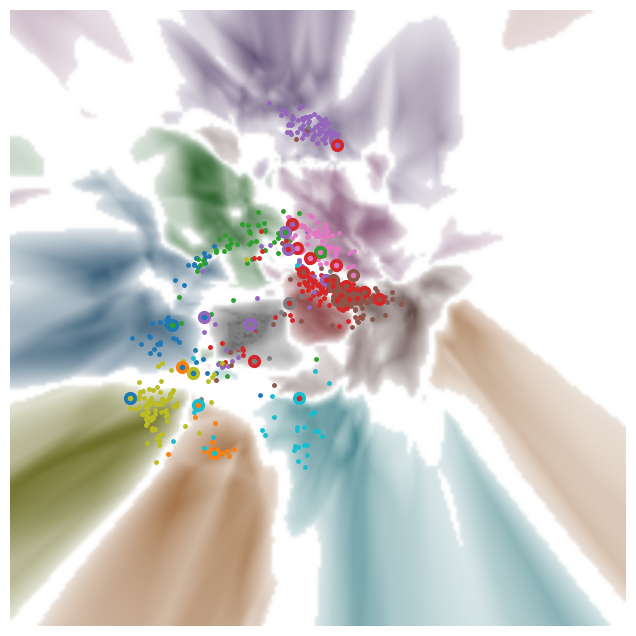

In [12]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 2/2 [00:00<00:00, 2264.13it/s]


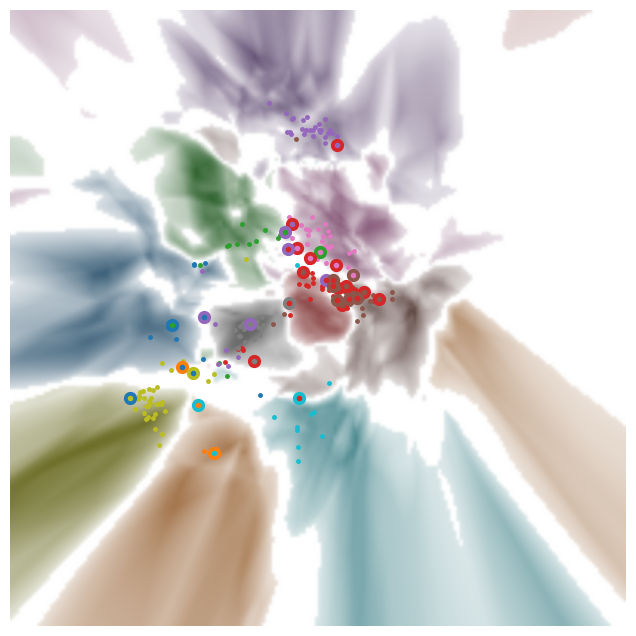

In [14]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_class],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]
print('RBF Kernel CKA, between np.dot(ref_train_data[pred_diff_list],S_for_diff) and tar_train_data[pred_diff_list]: {}'.format(np_cka.kernel_CKA(X, Y)))